In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
from datasets import train_test_random_split, load_dsprites
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAEDSprites
from utils import latent_transversal

In [4]:
dataset = load_dsprites("../datasets/dsprites.npz")
dataset = torch.from_numpy(dataset)

In [13]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [14]:
model = BetaVAEDSprites()
model.to(device)

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [15]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

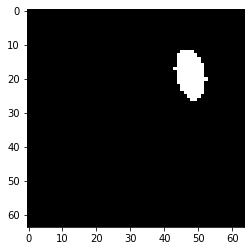

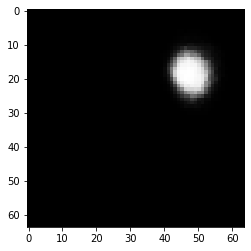

In [30]:
index = 100
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [5]:
len(dataset) / 64

11520.0

None


In [9]:
def compute_latent_gaussian_variance(model, dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    accumulator = torch.zeros(10)
    with torch.no_grad():
        for index, data in enumerate(loader):
            # shape of data is 64 x img_size
            _, _, logvar = model(data.float())
            accumulator = accumulator + logvar.div(2).exp().sum(0)
            if index % 1000 == 999:
                print('.', end='')
            del logvar
    return accumulator.div(len(dataset))

In [11]:
model_beta1_e40_alldata = torch.load('trained_models/betavae_beta1_e40_alldata.dat')
model_beta1_e40_alldata.cpu()
model_beta1_e40_alldata.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [13]:
latent_gaussian_variance_beta1 = compute_latent_gaussian_variance(model_beta1_e40_alldata, dataset)

...........

In [14]:
print(latent_gaussian_variance_beta1)

tensor([0.0094, 0.0634, 0.0134, 0.0451, 0.0390, 0.0524, 0.0099, 0.0142, 0.1327,
        0.0124])


In [1]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float().to(device)


NameError: name 'np' is not defined

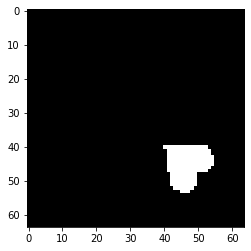

In [17]:
plt.imshow(torch.sigmoid(original.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [18]:
recon, mu, logvar = model_beta1_e40_alldata(original)

In [19]:
logvar.div(2).exp()

tensor([[0.0094, 0.0554, 0.0182, 0.0401, 0.0399, 0.0454, 0.0093, 0.0220, 0.2406,
         0.0106]], device='cuda:0', grad_fn=<ExpBackward>)

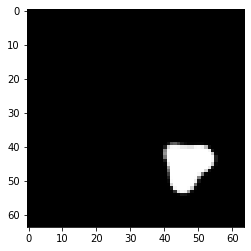

In [21]:
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

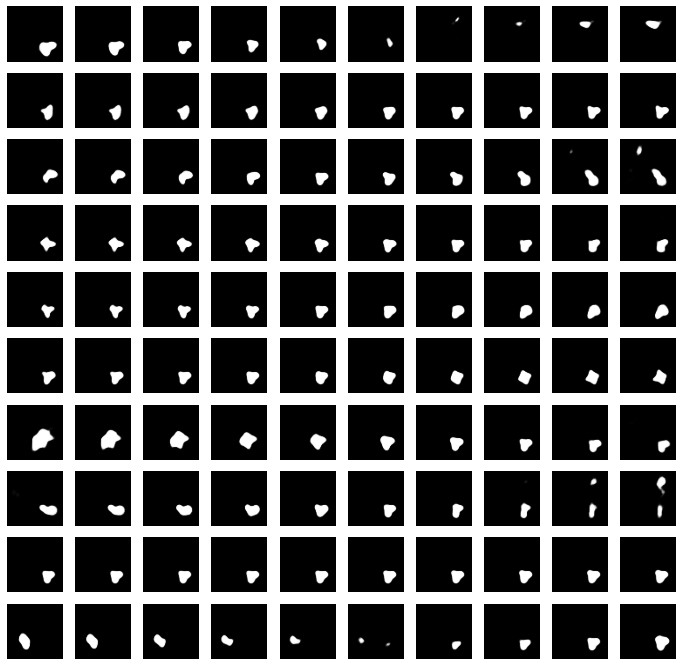

In [20]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model_beta1_e40_alldata, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [5]:
from utils import save_checkpoint, load_checkpoint

In [17]:
model = BetaVAEDSprites()
model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)



In [18]:
losslogger = []

In [19]:
import os
def load_checkpoint(model, optimizer, losslogger, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [21]:
model, optimizer, start_epoch, losslogger = load_checkpoint(
    model, optimizer, losslogger,
    'trained_models/betavae_beta4_e100_alldata.pth.tar')

=> loading checkpoint 'trained_models/betavae_beta4_e100_alldata.pth.tar'
=> loaded checkpoint 'trained_models/betavae_beta4_e100_alldata.pth.tar' (epoch 101)


In [22]:
torch.save(model, 'trained_models/betavae_beta4_e100_alldata.dat')

In [9]:
model(dataset[0].float().to(device))

(tensor([[-22.0443, -21.5564, -21.9400,  ..., -22.1780, -21.9837, -21.8645]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.6407,  0.3896,  1.2050, -0.0108, -0.7347,  1.5645,  0.0088, -0.5321,
           0.7589, -0.0401]], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[-5.9687, -4.9327, -6.1625, -0.0626, -6.8360, -7.9847, -0.0889, -8.4066,
          -8.3986, -0.0898]], device='cuda:0', grad_fn=<SliceBackward>))

In [13]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float().to(device)


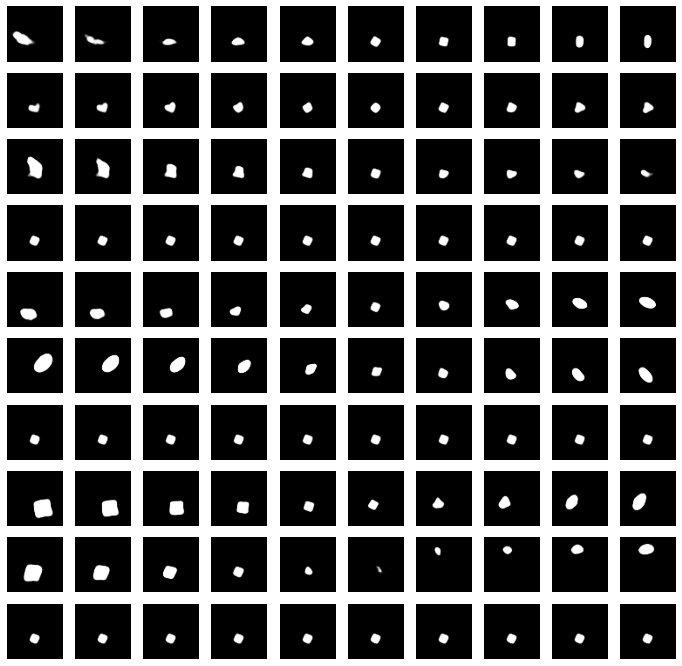

In [14]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()